<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [16]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/chemometrics.git
    !cd chemometrics; pip3 install -r requirements.txt
else:
    import sys
    sys.path.append('../../../')

import chemometrics

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sklearn
import imblearn
import shap
import numpy as np
import pandas as pd
import seaborn as sns

from chemometrics.utils import plot_learning_curve

shap.initjs()

Overview
--------
This notebook illustrates the analysis of NMR spectra of salmon mucus to predict breeding value and/or stock.  We will perform two tasks:
* Classification: Brood stock vs. Cull stock
* Regression: Predict Breeding Value as a function of measured spectra

In [5]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.31.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 4.15.0-167-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.11.2
pandas    : 1.3.5
shap      : 0.40.0
numpy     : 1.21.5
sys       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
sklearn   : 0.0
imblearn  : 0.9.0
matplotlib: 3.5.1
watermark : 2.3.0



# Exploratory Data Analysis

## Load Data

In [36]:
# This data was collected by NIST by Erin Legacki

In [107]:
df = pd.read_csv('./data/data_Fish_Mucus_BV_200115_actual data.csv')
df.dropna(axis=0, how='any', inplace=True) # Remove 2 rows with "nan"

In [108]:
# We are going to try to classify the samples as Brood vs. Cull
# We are also going to try to regress the Breeding Value
df = df.drop(['ID', 'Class', 'Strain','Fork Length (cm)','Weight (kg)'], axis=1)

In [109]:
df.head()

,Stock,Breeding Value,B7_4994,B7_4875,B7_4525,B7_3616,B7_3503,B7_3393,B7_1522,B7_1093,...,B0_9047,B0_8992,B0_8938,B0_8825,B0_8759,B0_8651,B0_8562,B0_8515,B0_1677,B0_1468
0,CULL,397.0,131305.45310,144981.26560,142388.8281,96999.42188,156190.8125,95217.79688,29787.84375,112778.8594,...,110548.06250,122697.2656,139708.01560,103893.0625,246991.5469,215101.6875,65581.21875,26646.21875,86967.81250,20274.75000
1,CULL,-91.0,183441.31250,209126.93750,201864.0625,127183.81250,206881.2188,117774.50000,18977.25000,165255.5625,...,110431.21880,121501.6875,125174.62500,89302.8125,214140.1250,212868.2813,65850.68750,27119.37500,71080.46875,35608.62500
2,CULL,344.0,206015.93750,255455.95310,262075.8125,139335.82810,237417.7188,151135.73440,15748.59375,205730.3125,...,256810.57810,265815.4219,260946.79690,178281.7656,414871.1250,377639.4219,109138.48440,54492.51563,81977.62500,18493.96875
3,CULL,132.0,7692.09375,24164.28125,8611.9375,17506.75000,5935.1250,32927.78125,15251.34375,-13094.3125,...,71889.03125,69318.4375,86390.09375,53759.6250,138607.2500,153938.9063,46037.78125,9949.40625,69577.68750,30906.34375
4,CULL,81.0,123934.34380,135644.43750,130603.5625,66523.73438,131626.4375,76109.89063,31055.37500,101598.0000,...,135593.29690,144686.1406,149021.18750,102828.2969,245571.5469,234731.1563,61604.43750,27374.95313,74492.90625,26447.07813


## Summarize

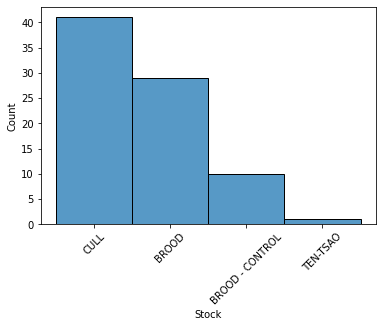

In [110]:
sns.histplot(df, x='Stock')
_ = plt.xticks(rotation=45)

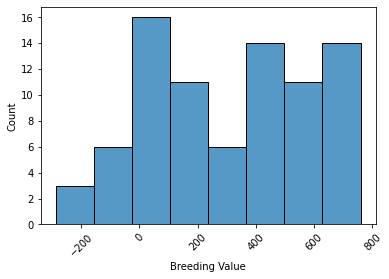

In [111]:
sns.histplot(df, x='Breeding Value')
_ = plt.xticks(rotation=45)

## Data Cleaning

In [112]:
df['Stock'].unique() # The Brood class has different 'Brood' names which needs to be standardized

array(['CULL', 'BROOD', 'BROOD - CONTROL', 'TEN-TSAO'], dtype=object)

In [113]:
def rename(name):
    if 'BROOD' in name:
        return 'BROOD'
    elif 'CULL' in name:
        return 'CULL'
    else:
        return name

In [114]:
df['Stock'] = df['Stock'].apply(rename) # Rename
indices = df[ 
    (df['Stock'] != 'BROOD') &
    (df['Stock'] != 'CULL')
].index
df.drop(indices, inplace=True) # Remove other categories

In [118]:
X_raw = df.drop(['Stock', 'Breeding Value'], axis=1).values
features = df.drop(['Stock', 'Breeding Value'], axis=1).columns

In [115]:
df.head()

,Stock,Breeding Value,B7_4994,B7_4875,B7_4525,B7_3616,B7_3503,B7_3393,B7_1522,B7_1093,...,B0_9047,B0_8992,B0_8938,B0_8825,B0_8759,B0_8651,B0_8562,B0_8515,B0_1677,B0_1468
0,CULL,397.0,131305.45310,144981.26560,142388.8281,96999.42188,156190.8125,95217.79688,29787.84375,112778.8594,...,110548.06250,122697.2656,139708.01560,103893.0625,246991.5469,215101.6875,65581.21875,26646.21875,86967.81250,20274.75000
1,CULL,-91.0,183441.31250,209126.93750,201864.0625,127183.81250,206881.2188,117774.50000,18977.25000,165255.5625,...,110431.21880,121501.6875,125174.62500,89302.8125,214140.1250,212868.2813,65850.68750,27119.37500,71080.46875,35608.62500
2,CULL,344.0,206015.93750,255455.95310,262075.8125,139335.82810,237417.7188,151135.73440,15748.59375,205730.3125,...,256810.57810,265815.4219,260946.79690,178281.7656,414871.1250,377639.4219,109138.48440,54492.51563,81977.62500,18493.96875
3,CULL,132.0,7692.09375,24164.28125,8611.9375,17506.75000,5935.1250,32927.78125,15251.34375,-13094.3125,...,71889.03125,69318.4375,86390.09375,53759.6250,138607.2500,153938.9063,46037.78125,9949.40625,69577.68750,30906.34375
4,CULL,81.0,123934.34380,135644.43750,130603.5625,66523.73438,131626.4375,76109.89063,31055.37500,101598.0000,...,135593.29690,144686.1406,149021.18750,102828.2969,245571.5469,234731.1563,61604.43750,27374.95313,74492.90625,26447.07813


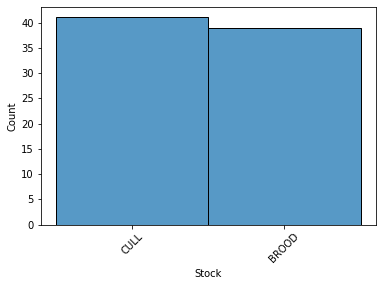

In [116]:
sns.histplot(df, x='Stock')
_ = plt.xticks(rotation=45)

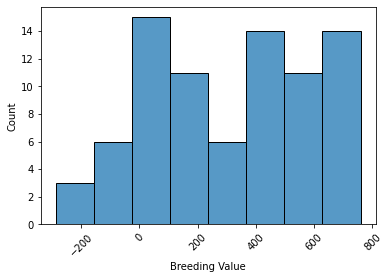

In [117]:
sns.histplot(df, x='Breeding Value')
_ = plt.xticks(rotation=45)

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def random_forest_importances(X, y, columns, test_size=0.2, n_estimators=100, ax=None):
    """
    Preliminary estimate of feature importance based on random forests.
    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=feature%20importance#sklearn.ensemble.RandomForestClassifier.feature_importances_
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=y)

    forest = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    forest.fit(X_train, y_train) # Tree-based classifiers do not need scaling/normalization

    importances = sorted(list(zip(columns, forest.feature_importances_)), key=lambda x:x[1], reverse=True)

    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(18,4))
        importance_df = pd.DataFrame(
            columns=['Feature', 'Importance'],
            data=importances,
        )
        plt.xticks(rotation=45)
        _ = sns.barplot(data=importance_df, x='Feature', y='Importance', ax=ax, orient='v')

    ax.set_xlabel('Feature Number')
    ax.set_ylabel('RF Feature Importance')

    return importances

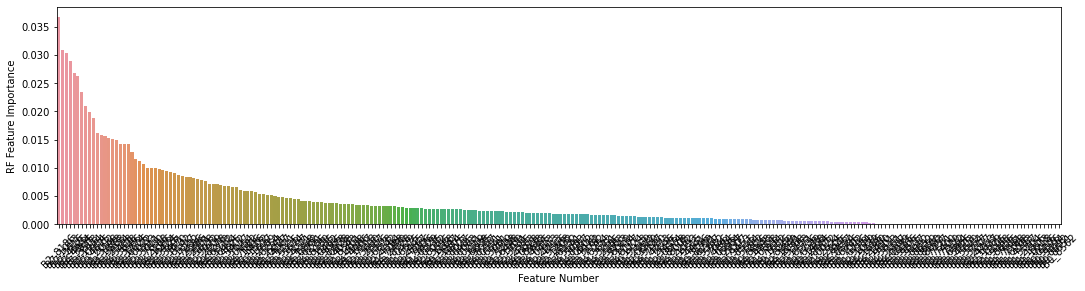

In [99]:
importances = random_forest_importances(
    X=X_raw,
    y=df['Stock'],
    columns=features
)

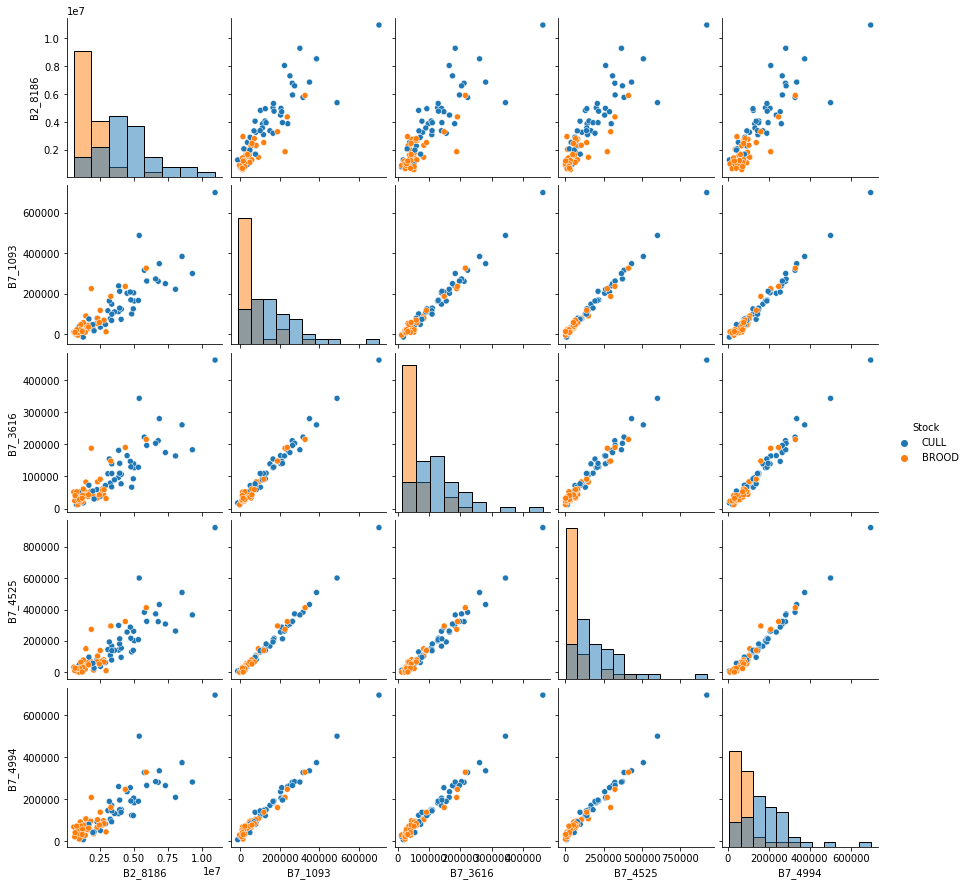

In [100]:
# Pairwise, these features do not show a lot of separation so this could be a tricky separation
sns.pairplot(df, 
             vars=[x_[0] for x_ in importances[:5]],
             diag_kind='hist', 
             hue='Stock')

## Simple Models

Text(0.5, 1.0, 'LDA')

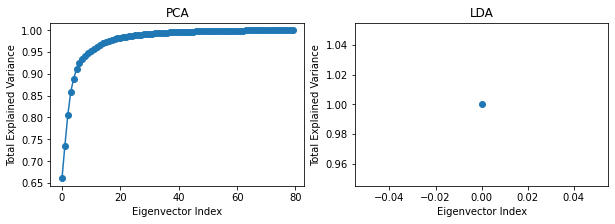

In [123]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA as PCA
from sklearn.preprocessing import StandardScaler

lda = LDA(solver='svd', shrinkage=None, n_components=1)
pca = PCA(whiten=False, random_state=0)

ss = StandardScaler()
X_scaled = ss.fit_transform(X_raw)

lda.fit(X_scaled, df['Stock'])
pca.fit(X_scaled)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax = axes.flatten()

ax[0].plot(np.cumsum(pca.explained_variance_ratio_), '-o')
ax[0].set_ylabel('Total Explained Variance')
ax[0].set_xlabel('Eigenvector Index')
ax[0].set_title('PCA')

ax[1].plot(np.cumsum(lda.explained_variance_ratio_), '-o')
ax[1].set_ylabel('Total Explained Variance')
ax[1].set_xlabel('Eigenvector Index')
ax[1].set_title('LDA')

In [124]:
%matplotlib notebook

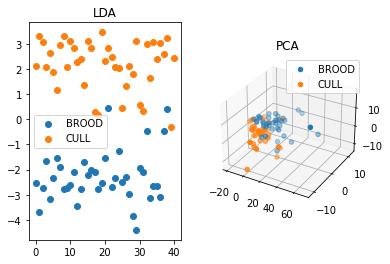

In [135]:
# LDA (supervised) separates well in a few dimensions, PCA (unsupervised) does not

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

X_new_lda = lda.transform(X_scaled)
X_new_pca = pca.transform(X_scaled)

ax = fig.add_subplot(121)
ax.set_title('LDA')
for stock in ['BROOD', 'CULL']:
    x_ = X_new_lda[df['Stock'].values == stock,:]
    ax.scatter(x=np.arange(len(x_)), y=x_[:,0], label=stock)
plt.legend(loc='best')

ax = fig.add_subplot(122, projection='3d')
ax.set_title('PCA')
for stock in ['BROOD', 'CULL']:
    x_ = X_new_pca[df['Stock'].values == stock,:]
    ax.scatter(x_[:,0], x_[:,1], x_[:,2], label=stock)
plt.legend(loc='best')

In [133]:
# LDA looks promising. In this case, we have exactly 2 known categories: BROOD and CULL. It is reasonable to 
# build a discrimination model since these are the ONLY possibilities. However, we could also train authentication
# models as well.

# Brood vs. Cull Classification Task

In [134]:
%matplotlib inline

## LDA Model

### Optimize Model

In [ ]:
# LDA can be used to directly classify objects
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
# Can do QDA also but not necessary

### SHAP Explanations

## PLS-DA (Discrimination) Models (Hard and Soft)

### Optimize Model

### SHAP Explanations

In [ ]:
# Soft model can be useful to detect outliers

# Breeding Value Regression Task